# A2 Image Stitching & Object Detection 

Student Name: Irene Huang 

Student ID : 260740689 

## 2 Image Stitching 

In [408]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [409]:
def warpPerspectivePadded(
        imgl, H, imgr_shape):
    """Performs an affine or Euclidean/rigid warp with padding.
    Parameters
    ----------
    imgl : image to be warped i.e. left image
    imgr : shape of static image i.e. shape of central image
    M : `3x3` Homography matrix.
    Returns
    -------
    src_warped : padded and warped source image
    """
    
    src = imgl
    dst_shape = imgr_shape
    M = H
    
    # it is enough to find where the corners of the image go to find
    # the padding bounds; points in clockwise order from origin
    _, src_w = src.shape[:2]
    lin_pts = np.array([
        [0, src_w],
        [0, 0],
        [1, 1]])
    # transform points
    transf_lin_pts = M.dot(lin_pts) #M[:, :2].dot(lin_pts) + M[:, 2].reshape(3, 1)
    transf_lin_pts /= transf_lin_pts[-1:,:]
    
    # find min and max points
    min_x = np.floor(np.min(transf_lin_pts)).astype(int)
    max_x = np.ceil(np.max(transf_lin_pts)).astype(int)

    # add translation to the transformation matrix to shift to positive values
    anchor_x = 0
    transl_transf = np.eye(3,3)
    if min_x < 0:
        anchor_x = -min_x
        transl_transf[0,2] = anchor_x
        
    shifted_transf = transl_transf.dot(M)
    shifted_transf /= shifted_transf[2,2]

    # create padded destination image
    dst_h, dst_w,_ = dst_shape
    dst_pad_w = anchor_x + max(max_x, dst_w)
    src_warped = cv2.warpPerspective(src, shifted_transf, (dst_pad_w, dst_h), borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return src_warped

#### 1 Compute SIFT keypoints and corresponding descriptors for left and central images.

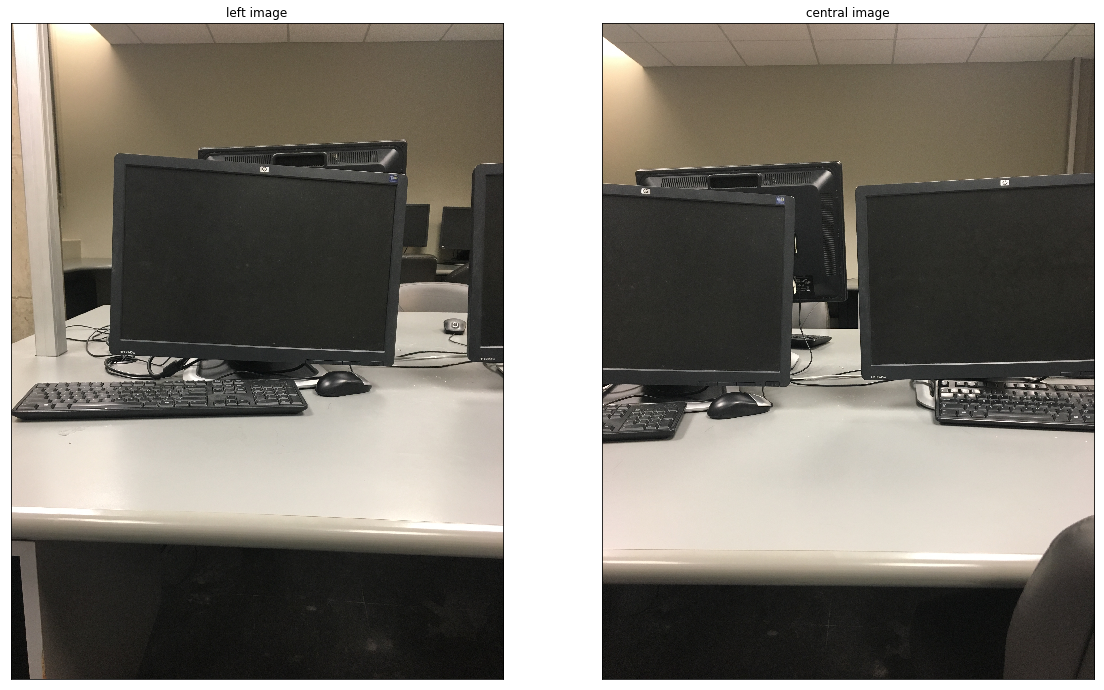

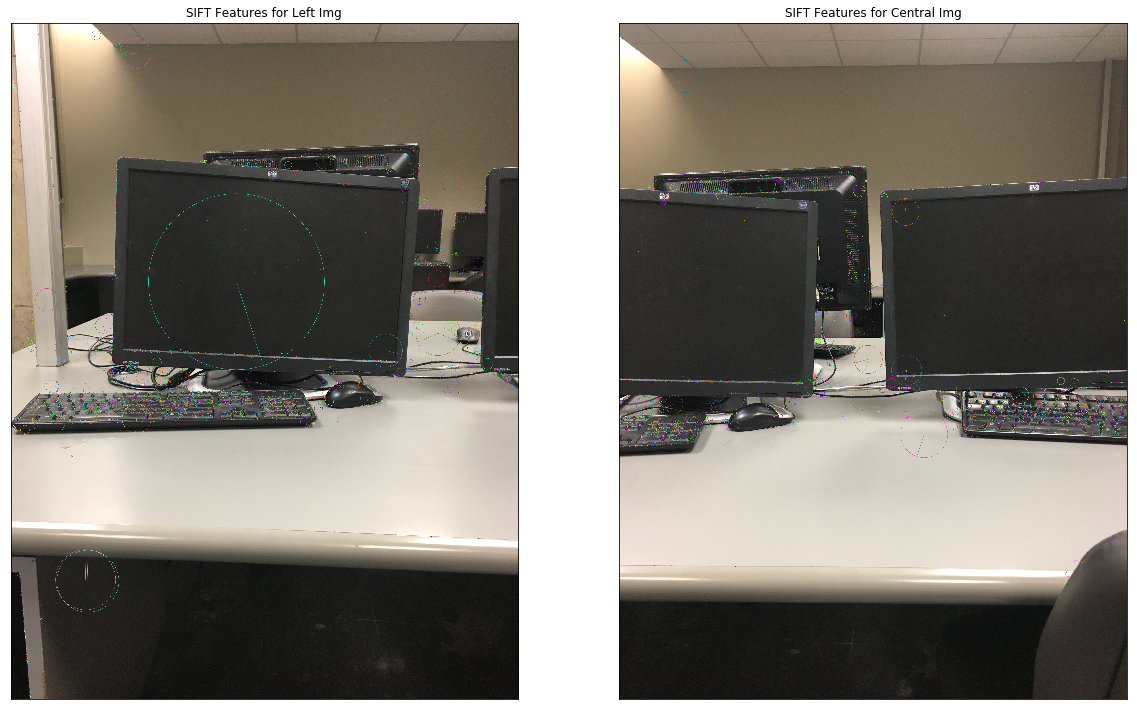

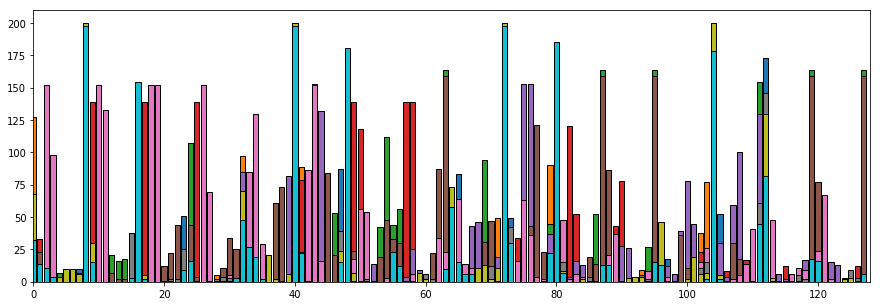

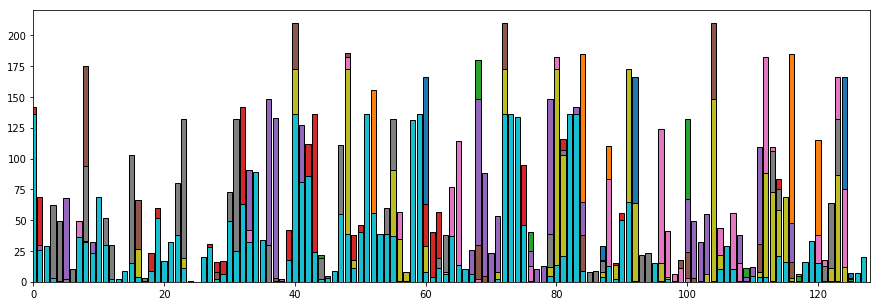

In [610]:
# read images 
img1 = cv2.imread("stitch1.JPG")
img2 = cv2.imread("stitch2.JPG")

imgleft_kp = img1.copy()
imgcenter_kp = img2.copy()

# conversion 
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
# img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

# display original images 
plt.figure(figsize=(30, 30))
plt.subplot(131), plt.imshow(img1)
plt.title("left image"), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(img2)
plt.title("central image"), plt.xticks([]), plt.yticks([])
# plt.subplot(133), plt.imshow(img3)
# plt.title("right image"), plt.xticks([]), plt.yticks([])

# Compute SIFT Keypoints 

# conversion
imgleft_kp = cv2.cvtColor(imgleft_kp, cv2.COLOR_BGR2RGB)
imgcenter_kp = cv2.cvtColor(imgcenter_kp, cv2.COLOR_BGR2RGB)
# imgright_kp = cv2.cvtColor(imgright_kp, cv2.COLOR_BGR2RGB)


# create SIFT objects
sift_obj = cv2.xfeatures2d.SIFT_create() 

# detect SIFT features, compute keypoint. Can pass a mask if want to search only a part of image
# Computer SIFT Descriptor
keypoint_left, descriptors_left = sift_obj.detectAndCompute(img1, None)  
keypoint_central, descriptors_central = sift_obj.detectAndCompute(img2, None)

# draw keypoints on left and central images 
    # draw small circles on the locations of the kepoints 
    # if pass cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, it will draw
    # a circle with size of keypoint and it will show its origintation 
    # ref: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_sift_intro/py_sift_intro.html
cv2.drawKeypoints(img1, keypoint_left, imgleft_kp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(img2, keypoint_central, imgcenter_kp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(imgleft_kp)
plt.title("SIFT Features for Left Img"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgcenter_kp)
plt.title("SIFT Features for Central Img"), plt.xticks([]), plt.yticks([])


# plot 10 SIFT descriptors
num = 10
plt.figure(figsize=(15,5))
for i in range(num):
    plt.bar(np.arange(0,128),descriptors_left[i], edgecolor='k')
    plt.xlim([0,128])
    

plt.figure(figsize=(15,5))
for j in range(num):
    plt.bar(np.arange(0,128),descriptors_central[j], edgecolor='k')
    plt.xlim([0,128])

plt.show()

#### 2 Find matching keypoints in two images and display the 20 best pairs.

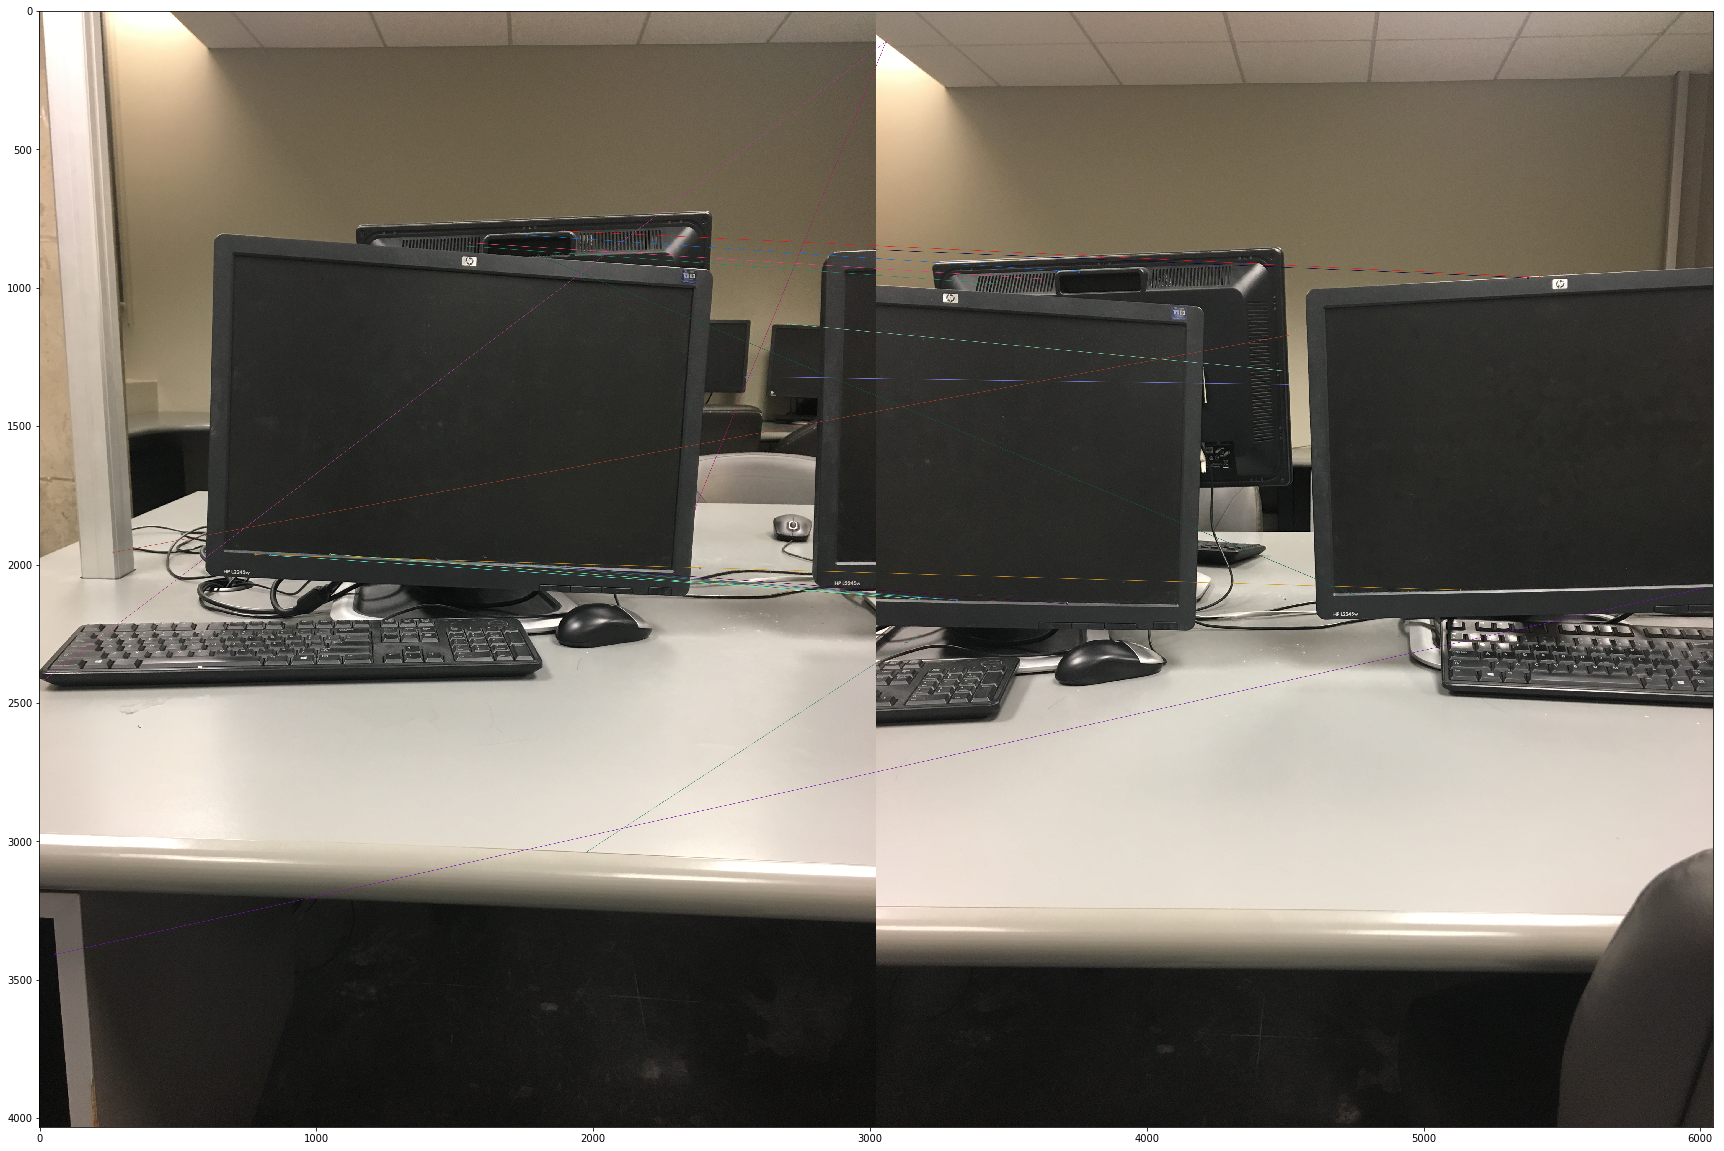

In [611]:
# Create BFMatcher object 

    # cv2.BFMatcher(): For each descriptor in the first set, this matcher finds 
    # the closest descriptor in the second set by trying each one. 
    # This descriptor matcher supports masking permissible matches 
    # of descriptor sets.
    # reference: https://docs.opencv.org/3.4/d3/da1/classcv_1_1BFMatcher.html#details

bf = cv2.BFMatcher() 

# Match descriptors in two images 
matches = bf.match(descriptors_left, descriptors_central)

# Sort matches in distance 
matches = sorted(matches, key = lambda x:x.distance)

# Draw keypoints on images 

imgMatch = cv2.drawMatches(img1, keypoint_left, img2,  keypoint_central, matches[:20], img1, flags=2)

plt.figure(figsize=(30,30))
plt.imshow(imgMatch)
plt.show()




#### 3 Find homography using RANSAC method. Implement RANSAC from scratch. Do not use OpenCV implementation. (6 points)
 – Steps to compute homography using RANSAC are given in Lecture 9 - slide 52.
 
 – Note on step 3: Compute H using opencv function findHomography with method=0.
 
 – Note on step 5: Before computing distance, convert projected key- points from homogeneous to euclidean space using opencv function convertPointsFromHomogeneous.

4
[[-6.77391336e+00  4.06056478e+00  1.12923767e+03]
 [-1.57001075e+01  9.80593107e+00  2.18736602e+03]
 [-6.73572171e-03  4.15739597e-03  1.00000000e+00]]


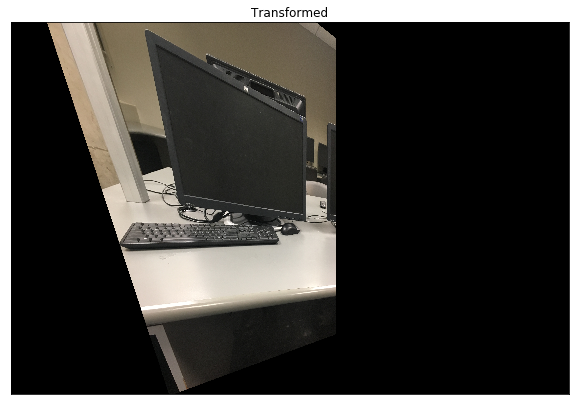

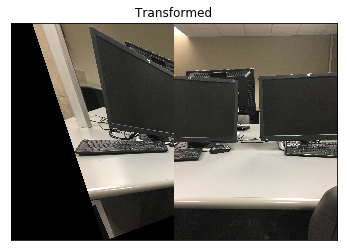

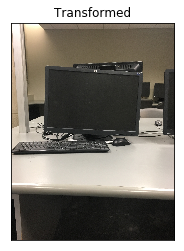

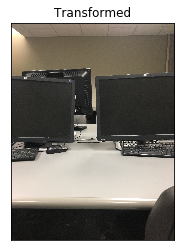

'\n[[ 3.15643745e+00  1.14696556e+00 -6.49005141e+02]\n [ 1.19398873e+00  3.10951696e+00 -3.16249974e+03]\n [ 5.03960470e-04  3.25873337e-04  1.00000000e+00]]\n \n'

In [661]:
# TODO 

def ransac(mpc, mpl): 
    # Arrange matching keypoints in two lists 
    

    # set the number of samples N
    numOfSamples = 200
    numMatches = 4
    sampleCount = 0
    distanceThresh = 4
    distance_array = []
    numOfInlier = 0
    maxInlier = 0
    finalH = []

    while sampleCount < numOfSamples:  # repeat for N times 

        # choose 4 random potential matches 
        random1 = np.random.randint(0, len(mpc))
        random2 = np.random.randint(0, len(mpc))
        random3 = np.random.randint(0, len(mpc))
        random4 = np.random.randint(0, len(mpc))
        array_center = np.array([mpc[random1], mpc[random2],mpc[random3],mpc[random4]]) # choose value in array
        array_left = np.array([mpl[random1], mpl[random2],mpl[random3],mpl[random4]]) 

        # compute H using four potential matches 
        H, __ = cv2.findHomography(array_center, array_left, 0)
        
        # calculate calculate distance and count inliers 
        for i in range (0, len(array_center)):  # at most four times 

            # project points from x to x' for each potentially matching pair Xi' = HXi
            mpc_reshape = np.array([array_center[i].item(0), array_center[i].item(1), 1])
            denominator = H[2].dot(mpc_reshape.transpose())
            projectpoints = np.array([[H[0].dot(mpc_reshape.transpose())/denominator, H[1].dot(mpc_reshape.transpose())/denominator, 1]])

            # convert keypoints to eucliean space 
            estimate_array = cv2.convertPointsFromHomogeneous(projectpoints)
#             estimate_array = projectpoints
            estimate_array = [[estimate_array[0].item(0), estimate_array[0].item(1)]]
          
            # count points with projected distance < t using a for loop 
            est_x = estimate_array[0][0]
            est_y = estimate_array[0][1]
            array_left_x = array_left[i].item(0)
            array_left_y = array_left[i].item(1)

            
            # calculate distance 
            distance = np.sqrt(np.square(est_x - array_left_x) + np.square(est_y - array_left_y))
#             print("distance")
#             print(distance)

            # count inliers with distance threshold 
            if distance < distanceThresh and distance != 0:
#                 print(distance)
                numOfInlier = numOfInlier + 1 
                # calculate H using the largest set of inliers 
                

        # update the best inliers
        if numOfInlier > maxInlier: 
            finalH, __ = cv2.findHomography(array_center, array_left, 0)
            maxInlier = numOfInlier 
            print(maxInlier)
            
#             print(maxInlier)

        # reset values 
        numOfInlier = 0 

        # update the number of samples 
        sampleCount = sampleCount + 1
        
    return finalH 

# print("mpc")

GoodMatches = [] 
for j, k in enumerate(matches): 
    if k.distance < 1000: 
        GoodMatches.append((k.trainIdx, k.queryIdx))

mpc = np.float32([keypoint_central[j].pt for(j, __) in GoodMatches])
mpl = np.float32([keypoint_left[j].pt for(__, j) in GoodMatches])

finalH = ransac(mpc, mpl)
print(finalH)
H = []
H.append([ 3.15643745e+00,  1.14696556e+00, -6.49005141e+02])
H.append([ 1.19398873e+00,  3.10951696e+00, -3.16249974e+03])
H.append([ 5.03960470e-04,  3.25873337e-04,  1.00000000e+00])

# (img2.shape[1]+img1.shape[1], img2.shape[0], _)
# transformed = warpPerspectivePadded(img1, finalH, img2.shape)
# finalH, __ = cv2.findHomography(mpc, mpl, cv2.RANSAC, 5)
transformed = cv2.warpPerspective(img1, np.asarray(H), (img2.shape[1]+img1.shape[1],img2.shape[0])) # imgr: image to transform, and keep the left one 
# transformed = cv2.warpPerspective(img1, finalH, (img2.shape[1]+img1.shape[1],img2.shape[0]))

# print(transformed)                                    
                                    
plt.figure(figsize=(10,10))
plt.imshow(transformed), plt.title("Transformed")
plt.xticks([]), plt.yticks([])
plt.show() 

glued = transformed.copy() 
glued[:,img2.shape[1]:,:]=img2
plt.imshow(glued), plt.title("Transformed")
plt.xticks([]), plt.yticks([])
plt.show() 

plt.imshow(img1), plt.title("Transformed")
plt.xticks([]), plt.yticks([])
plt.show()

plt.imshow(img2), plt.title("Transformed")
plt.xticks([]), plt.yticks([])
plt.show() 

"""
[[ 3.15643745e+00  1.14696556e+00 -6.49005141e+02]
 [ 1.19398873e+00  3.10951696e+00 -3.16249974e+03]
 [ 5.03960470e-04  3.25873337e-04  1.00000000e+00]]
 
"""


#### 4 Apply transformation to left image. Central image should not be trans- formed. You are given a function warpPerspectivePadded. Use this function instead of OpenCV function warpPerspective for image trans- formation.

In [662]:
# import function from another jupyter notebook 
# import import_ipynb
# import warpPerspectivePadded

# from warpPerspectivePadded import warpPerspectivePadded

# from ipynb.fs.full.warpPerspectivePadded import warpPerspectivePadded

# warpPerspectivePadded(imgl, H, imgr_shape)
# image 1

# 
# transformed = cv2.warpPerspective(img1, finalH, (img2.shape[1]+img1.shape[1], img2.shape[0])) 


#### 5 Stitch transformed left image and original central image together using pyramid image blending

In [663]:
# define pyramid_blending function 
# img1: left image 
# img2: right image 
# level: Laplacian level 

def pyramid_blending(img1, img2, level): 
    # generate Gaussian pyramid for img1 and img2
    GA = img1.copy()
    gpA = [GA]
    for i in range(level):
        GA = cv2.pyrDown(GA) # blur image and downsample 
        gpA.append(GA)
    
    GB = img2.copy()
    gpB = [GB]
    for i in range(level):
        GB = cv2.pyrDown(GB)
        gpB.append(GB)
        
    # generate Laplacian Pyramid for img1 and img2 
    lpA = [gpA[level-1]]
    lpB = [gpB[level-1]]
    
    for j in range(level-1, 0, -1):  # decrement by 1 each time 
        heightA, widthA, _ = gpA[j-1].shape
        heightB, widthB, _ = gpB[j-1].shape
        GE = cv2.pyrUp(gpA[j],dstsize=(widthA, heightA))
        L = cv2.subtract(gpA[j-1],GE)
        lpA.append(L)
        GE = cv2.pyrUp(gpB[j], dstsize=(widthB, heightB))
        K = cv2.subtract(gpB[j-1],GE)
        lpB.append(K)
    
    # add img1 and img2 with equal weight 
    LS = [] 
    for la,lb in zip(lpA, lpB):
        r, c, d = la.shape
        ls = np.hstack((la[:,0:c//2], lb[:,c//2:]))
        LS.append(ls)
    
    ls = LS[0]
    for k in range(1,level):
        height,width,_ = LS[k].shape
        ls = cv2.pyrUp(ls, dstsize=(width,height))
        ls = cv2.add(ls, LS[k])
    
    return ls.astype(np.uint8)   


(<matplotlib.image.AxesImage at 0x11c74a128>,
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

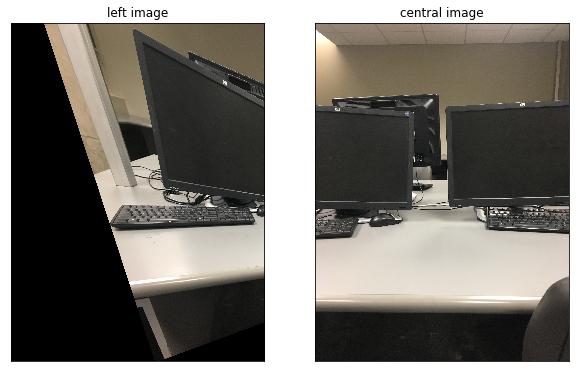

In [664]:
# stitch transformed images

blend_left = transformed[:,:img1.shape[1]]
blend_central = glued[:,img2.shape[1]:,:]


# stitch transformed left and central image using pyramid image blending 
blend_image = pyramid_blending(blend_left, blend_central, 6) 

# display seperate images 
plt.figure(figsize=(10,10))
plt.subplot(121), plt.title("left image")
plt.imshow(blend_left), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.title("central image") 
plt.imshow(glued[:,img2.shape[1]:,:]), plt.xticks([]), plt.yticks([])

#### 6 Display stitched image.

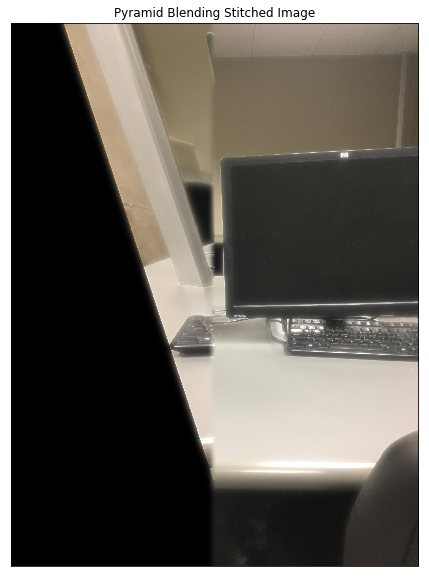

In [665]:
# display stitched image using pyramid blending
plt.figure(figsize=(10,10))
plt.imshow(blend_image), plt.title("Pyramid Blending Stitched Image")
plt.xticks([]), plt.yticks([])
plt.show()


#### Now let’s stitch above resultant image with a right image.
#### 7 Compute SURF keypoints and corresponding descriptors for above stitched image and right image.

4332
19509


(Text(0.5, 1.0, 'SURF Features for Central Img'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

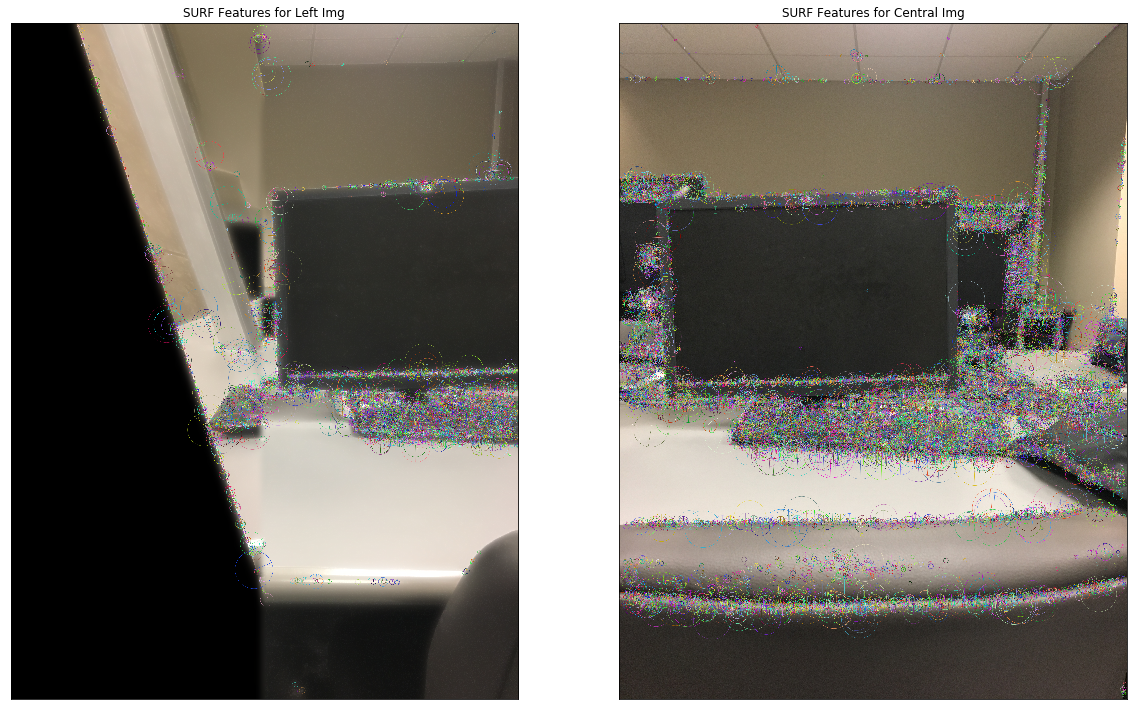

In [666]:
left_img = blend_image.copy() 
right_img = cv2.imread("stitch3.JPG")

right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)


# Convert to gray scale 
left_img_gray = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY) 
right_img_gray = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)


left_img_result = left_img.copy()
right_img_result = right_img.copy() 

# create SURF object 
surf = cv2.xfeatures2d.SURF_create() 

# image should be im gray scale (reference: 
# https://docs.opencv.org/2.4/modules/nonfree/doc/feature_detection.html)
# in SURF.detectAndCompute(img, None)

# compute SURF keypoints and descriptors 
keypoint_left, descriptor_left = surf.detectAndCompute(left_img_gray, None)
surf = cv2.xfeatures2d.SURF_create() 
keypoint_right, descriptor_right = surf.detectAndCompute(right_img_gray, None)

print(len(keypoint_left))
print(len(keypoint_right))

# draw keypoints 
cv2.drawKeypoints(left_img, keypoint_left, left_img_result,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(right_img, keypoint_right, right_img_result,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# display images with keypoints 
plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(left_img_result)
plt.title("SURF Features for Left Img"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(right_img_result)
plt.title("SURF Features for Central Img"), plt.xticks([]), plt.yticks([])

#### 8 Find matching keypoints in two images and display the 20 best pairs.

In [673]:
# Create BFMatcher object 
bf = cv2.BFMatcher() 

# Match descriptors in two images 
matches = bf.match(descriptor_right, descriptor_left)

# matches = bf.knnMatch(descriptor_right, descriptor_left, k=10)
   
# Sort matches in distance 
matches = sorted(matches, key = lambda x:x.distance)

# Draw keypoints on images 
# imgMatch = cv2.drawMatchesKnn(left_img, keypoint_left, right_img, keypoint_right, matches[:20], right_img, flags=2)
imgMatch = cv2.drawMatches(left_img, keypoint_left, right_img, keypoint_right, matches[:20], right_img, flags=2)
plt.figure(figsize=(20,20)), plt.xticks([]), plt.yticks([])
plt.imshow(imgMatch), plt.title("Matching Keypoints")
plt.show()

error: OpenCV(3.4.2) /Users/travis/build/skvark/opencv-python/opencv/modules/features2d/src/draw.cpp:211: error: (-215:Assertion failed) i1 >= 0 && i1 < static_cast<int>(keypoints1.size()) in function 'drawMatches'


#### 9 Find homography using RANSAC method. Use above implemented RANSAC function. Do not use OpenCV implementation.

In [671]:
GoodMatches = [] 
for j, k in enumerate(matches): 
    if j.distance < 0.5 * k.distance: 
        GoodMatch.append([j]) 
#     GoodMatches.append((k.trainIdx, k.queryIdx))
        
mpc = np.float32([keypoint_left[j].pt for(j, __) in GoodMatches])
mpl = np.float32([keypoint_right[j].pt for(__, j) in GoodMatches])
finalH = ransac(mpc, mpl)
print(finalH)

transformed = cv2.warpPerspective(right_img, finalH, (right_img.shape[1]+left_img.shape[1],left_img.shape[0])) # imgr: image to transform, and keep the left one 
# transformed = cv2.warpPerspective(img1, finalH, (img2.shape[1]+img1.shape[1],img2.shape[0]))                                  
                                    
plt.figure(figsize=(10,10))
plt.imshow(transformed), plt.title("Transformed")
plt.xticks([]), plt.yticks([])
plt.show() 

glued = transformed.copy() 
glued[:,right_img.shape[1]:,:]=right_img
plt.imshow(glued), plt.title("Transformed")
plt.xticks([]), plt.yticks([])
plt.show() 


AttributeError: 'int' object has no attribute 'distance'

#### 10 Apply transformation to right image. The stitched image should not be transformed. Use OpenCV function warpPerspective for image transfor- mation.

In [91]:
import import_ipynb
import warpPerspectivePadded

In [92]:
# import function from another jupyter notebook 


# warpPerspectivePadded(imgl, H, imgr_shape)
# right_img
transformed = warpPerspectivePadded(right_img, finalH, (left_img.shape[1]+right_img.shape[1], left_img.shape[0])
                                    
plt.figure(figsize=(30,30))
plt.imshow(transformed), plt.title("Transformed")
plt.xticks([]), plt.yticks([])
plt.show()  

SyntaxError: invalid syntax (<ipython-input-92-8e9e7d801a02>, line 8)

#### 11 Stitch transformed right image and already stitched left and central images together using linear image blending.

In [ ]:
# img_width: image width
# ramp_index: center ramp index
# start: starting ramp value 
# end: ending ramp value 
def linear_blending(img_width, ramp_width, ramp_index, start, end):
    array = np.zeros((img_width))
    step = (end-start)/(ramp_width-1)
    index = round(ramp_width - (ramp_width/2))
    for i in range(ramp_width): 
        array[index] = start + step * i 
        index = index + 1 
    
    a[index:] = 1
    return array 

In [ ]:
new_width = right_img.shape[1] + left_img.shape[1]  
image1 = np.zero((left_img.shape[0], new_width, 3))  # need .astype(np.uint8)?? 
image2 = transformed

col, row = image1.shape
real = np.vstack((image1[:round(row/2),:], image2[round(col/2):,:]))

# apply linear blending 
ramp_width = 50
alpha = linear_blending(new_width, ramp_width, round(new_width/2) 0, 1)

# calculate final image
finalImage = (1-alpha.reshape(-1,1,1)) * image1 + alpha.reshape(-1,1,1)*image2
finalImage = np.uint8(finalImage)

#### 12 Display final panoramic image. You can crop panoramic image to remove excess zero-padding; however it is not compulsory. 

In [ ]:
# display image
plt.figure(figsize=(30,30))
plt.imshow(finalImage), plt.title("Final Image")
plt.xticks([]), plt.yticks([]), plt.show() 

#### 13 Compare and comment on effectiveness of pyramid and linear blending. Discuss the pros and cons of both methods. 

In [ ]:
# TODO 




# 3 Object Detection 

#### Training 
#### 1 Resize the training images to 128 × 128

In [682]:
import os 

# read images 
train = [] 
dir_ = './train_set/'
image_list = os.listdir(dir_)
size = (128, 128)

# resize images
for file in image_list: 
    image = cv2.imread(dir_ + file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, size)
    
    # put in the list 
    train.append(image)
    
print(len(train))

30


#### 2 Compute HoG features using cell size of 4 × 4 pixels, block size of 2 × 2 cells and 9 orientation bins
(Suggestion: Make a function which takes list of images as argument and delivers list of HoG features as output. The same function can be used during testing.) 

In [ ]:
# define HoG function with image list, cell size, block size 
# and number of orientation bins as inputs 
def HoG(image_list, cell_size, block_size, numberOfBins):